To run widget on your local machine:

1. Clone this repository into your local machine by running the following code in terminal:  
    git clone https://github.com/abbystokes/wildfire-risk-ml
2. Download and unzip the fire scar data for Maule from PANGEA: https://doi.pangaea.de/10.1594/PANGAEA.941127
2. Make sure the scar shape files are stored in your working directory with the following format:
    Fire_CL-ML_Maule > FireScar_CL-ML_Maule_[year] > [shape files]
Where each year file contains all the corresponding files (.cpg, .dbf, .fix, .prj, .shp, .shx, .tif) for each fire incident from that year.
3. Run this notebook in the working directory

Dropdown(description='Fire ID:', options=(1, 3, 5, 6, 8, 9, 10, 14, 16, 17, 18, 19, 22, 25, 27, 28, 29, 33, 34…

Output()

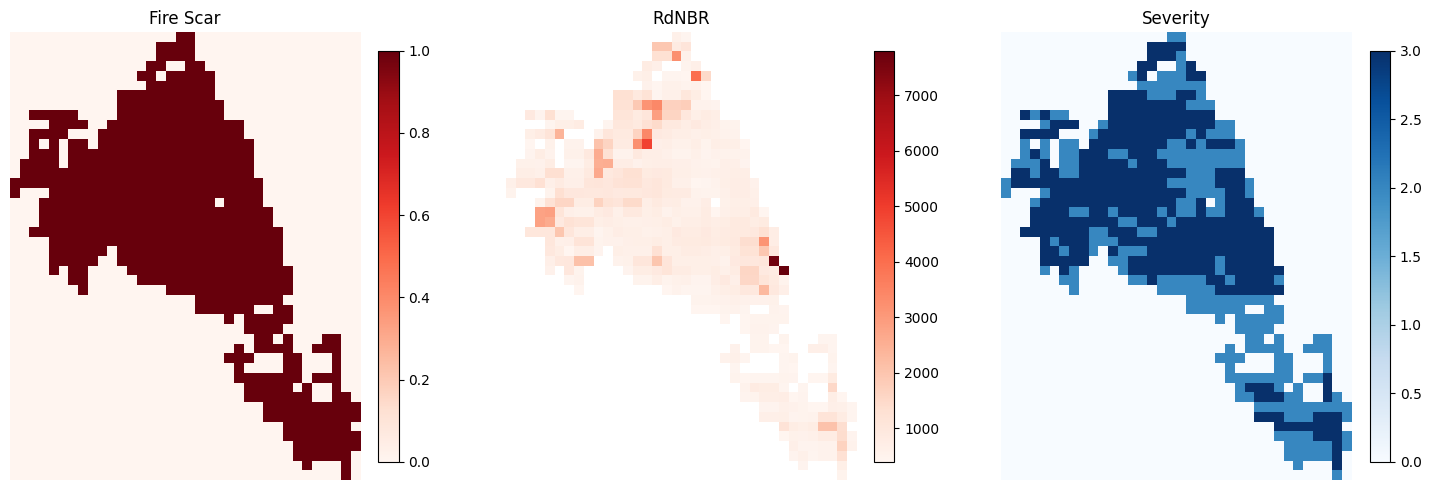

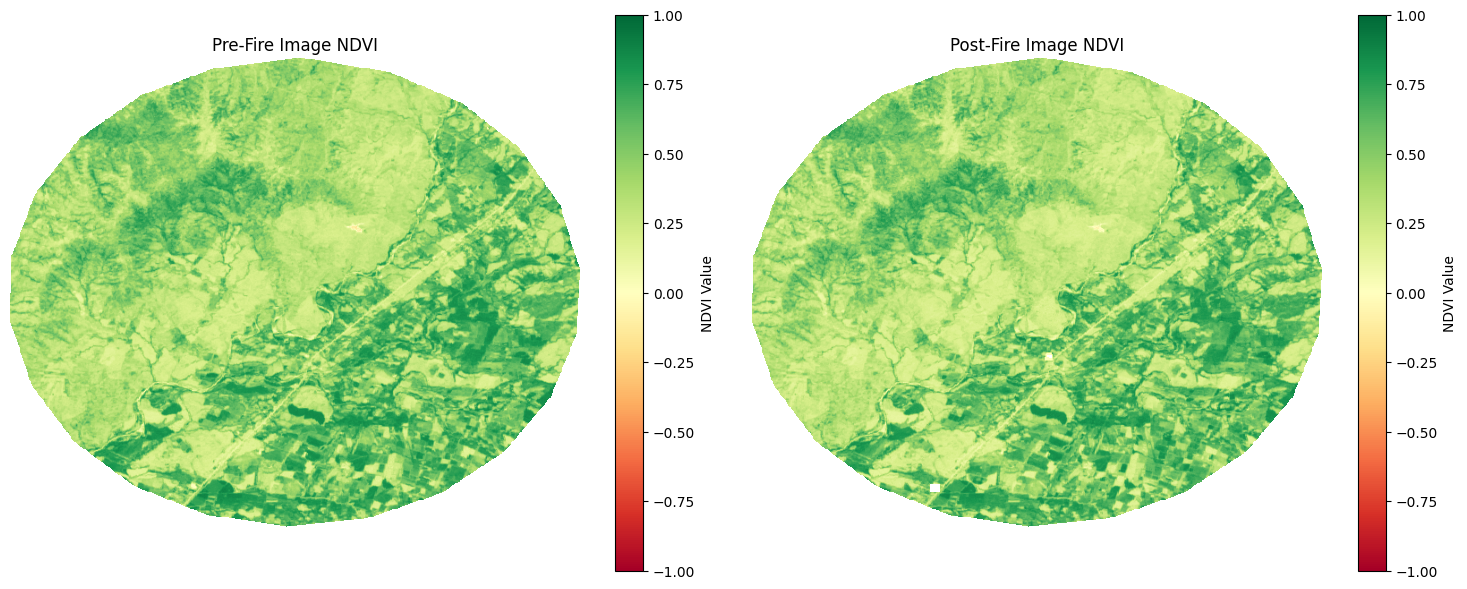

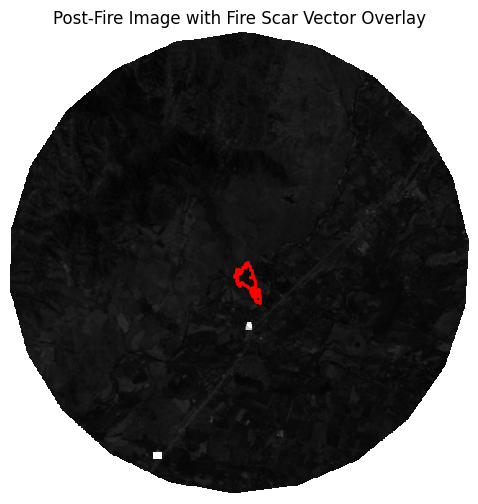

In [1]:
# Widget to vizualize different fire events over time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rasterio
import geopandas as gpd
import ipywidgets as widgets
from IPython.display import display
from rasterio.plot import show

# Read in the data
df = pd.read_excel("FireScar_CL_Summary_1985-2018.xlsx")
regions = gpd.read_file("Regiones/Regional.shp")

# Fix CRS for regions
regions = regions.to_crs("EPSG:4326")
df = df[df['FireScar'] == 1]  # Filter to just files that have fire scar
df = df[df['Region_CONAF'] == 'Maule']

# Dropdown widget for selecting Fire ID
#fire_ids = df[['IgnitionDate_CONAF']]
fire_ids = df.index.tolist()
fire_dropdown = widgets.Dropdown(
    options=fire_ids,
    description='Fire ID:',
    style={'description_width': 'initial'}
)

# Function to generate plots
def plot_fire(fire_id):
    example_fire = df.loc[fire_id]
    fire_season = example_fire["FireSeason"]
    folder = f"Fire_CL-ML_Maule/FireScar_CL-ML_Maule_{fire_season}"
    file_names = {
        "Fire Scar": (example_fire["FireScarImgName"], "Reds"),
        "RdNBR": (example_fire["RdNBRImgName"], "Reds"),
        "Severity": (example_fire["SeverityImgName"], "Blues"),
    }

    pre_fire_path = os.path.join(folder, example_fire["PreFireImgName"])
    post_fire_path = os.path.join(folder, example_fire["PostFireImgName"])
    fire_scar_path = os.path.join(folder, example_fire["FireScarVectorName"])

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, (title, (file_name, cmap)) in zip(axes, file_names.items()):
        file_path = os.path.join(folder, file_name)
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                img = src.read(1)
                im = ax.imshow(img, cmap=cmap)
                ax.set_title(title)
                ax.axis("off")
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        else:
            ax.set_title(f"{title}\n(File Not Found)")
            ax.axis("off")
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    with rasterio.open(pre_fire_path) as src:
        ndvi = src.read(7)
        img = axes[0].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
        axes[0].set_title('Pre-Fire Image NDVI')
        axes[0].axis('off')
        plt.colorbar(img, ax=axes[0], label='NDVI Value')

    with rasterio.open(post_fire_path) as src:
        ndvi = src.read(7)
        img = axes[1].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
        axes[1].set_title('Post-Fire Image NDVI')
        axes[1].axis('off')
        plt.colorbar(img, ax=axes[1], label='NDVI Value')
    plt.tight_layout()
    plt.show()

    with rasterio.open(post_fire_path) as src:
        fig, ax = plt.subplots(figsize=(6, 6))
        show(src, ax=ax, cmap='gray')

    fire_scar_gdf = gpd.read_file(fire_scar_path)
    fire_scar_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
    ax.set_title('Post-Fire Image with Fire Scar Vector Overlay')
    ax.axis('off')
    plt.show()

# Display dropdown and link it to the function
output = widgets.Output()

def on_fire_change(change):
    with output:
        output.clear_output(wait=True)
        plot_fire(change.new)

fire_dropdown.observe(on_fire_change, names='value')

display(fire_dropdown, output)

# Display initial plot
plot_fire(fire_ids[0])  # Show the first fire incident initially
